In [1]:
import sys
sys.path.append('..\\..\\..')

In [2]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


In [3]:
import tensorflow as tf

In [4]:
tf.__version__

'2.0.0'

In [5]:
dataset_name = 'dsprites'

In [6]:
import tensorflow_datasets as tfds

info = tfds.builder(dataset_name).info

print(info)

tfds.core.DatasetInfo(
    name='dsprites',
    version=0.1.0,
    description='dSprites is a dataset of 2D shapes procedurally generated from 6 ground truth
independent latent factors. These factors are *color*, *shape*, *scale*,
*rotation*, *x* and *y* positions of a sprite.

All possible combinations of these latents are present exactly once,
generating N = 737280 total images.

### Latent factor values

*   Color: white
*   Shape: square, ellipse, heart
*   Scale: 6 values linearly spaced in [0.5, 1]
*   Orientation: 40 values in [0, 2 pi]
*   Position X: 32 values in [0, 1]
*   Position Y: 32 values in [0, 1]

We varied one latent at a time (starting from Position Y, then Position X, etc),
and sequentially stored the images in fixed order.
Hence the order along the first dimension is fixed and allows you to map back to
the value of the latents corresponding to that image.

We chose the latents values deliberately to have the smallest step changes
while ensuring that all pixel outp

In [7]:
intermediate_dim = 20
inputs_shape=(64, 64, 1) # image shape
batch_size = 100
latent_dim = 50

In [8]:
TRAIN_BUF = 600
TEST_BUF = 100


In [9]:
import tensorflow_datasets as tfds
# Construct a tf.data.Dataset
train_ds = tfds.load(name=dataset_name, split=tfds.Split.TRAIN).shuffle(TRAIN_BUF).batch(batch_size)
try:
    test_ds = tfds.load(name=dataset_name, split=tfds.Split.TEST).shuffle(TEST_BUF).batch(batch_size)
except:
    test_ds = tfds.load(name=dataset_name, split=tfds.Split.TRAIN).shuffle(TEST_BUF).batch(batch_size)


In [10]:
_instance_scale=1.0
for data in train_ds:
    _instance_scale = float(data['image'][0].numpy().max())
    break

In [11]:
enc_lays2 = [
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Flatten(),
    # No activation
    tf.keras.layers.Dense(latent_dim)
]

dec_lays2 = [
    tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
    tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
    tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
    
    # No activation
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME")
]

In [12]:
#Not used here
enc_mean_lays = [tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu')]

enc_var_lays = [tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu')]

dec_lays = [tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu')]

## First Time

In [13]:
model_name = dataset_name+'AE'

In [14]:
recoding_dir='..\\..\\..\\recoding\\'+model_name

In [15]:
import os

In [16]:
os.path.join(recoding_dir, model_name)

'..\\recoding\\dspritesAE\\dspritesAE'

In [17]:
os.getcwd()

'C:\\Git\\test_run\\Generative_Models\\notebooks'

In [18]:
from training.autoencoders.AE import AE

Using TensorFlow backend.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [19]:
variables_params = \
[
    {
        'name': 'inference', 
        'inputs_shape':inputs_shape,
        'outputs_shape':latent_dim,
        'layers': enc_lays2
    }
    ,
    
        {
        'name': 'generative', 
        'inputs_shape':latent_dim,
        'outputs_shape':inputs_shape,
        'layers':dec_lays2
    }
]

In [20]:
_restore = os.path.join(recoding_dir, 'var_save_dir')

In [21]:
_restore

'..\\recoding\\dspritesAE\\var_save_dir'

In [22]:
ae = AE( 
    model_name=model_name, 
    inputs_shape=inputs_shape,
    outputs_shape=inputs_shape,
    latent_dim=latent_dim,
    variables_params=variables_params, 
    restore=None
    )

Model: "inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 31, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                720050    
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                20

  WARNING  | None


Model: "generative"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1568)              79968     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 4096)              3

  WARNING  | None


In [23]:
import numpy as np
n_generated = 36
random_latent = np.random.normal(size=[n_generated, latent_dim])
#np.save(file='random_latent.npy', arr=random_latent)
#random_latent = tf.constant(np.load(file='..\\data\\random_latent.npy'))

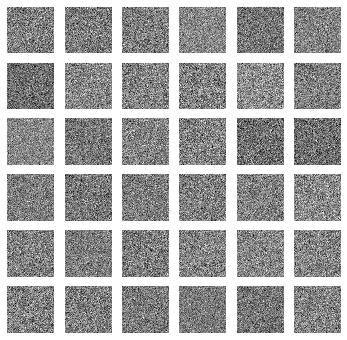

  ERROR    | No former training found ... 
Epochs Progress:   0%|                                                                         | 0/100 [00:00<?, ?it/s]

  INFO     | Training ... 
Epochs Progress, Training Iterations 1:   0%|                                                  | 0/100 [00:39<?, ?it/s]

KeyboardInterrupt: 

In [24]:
ae.fit(
    train_dataset=train_ds, 
    test_dataset=test_ds,
    instance_names=['image'],
    epochs=100,
    learning_rate=1e-3,
    random_latent=random_latent,
    recoding_dir=recoding_dir,
    gray_plot=True,
    generate_epoch=5,
    save_epoch=5
)

In [ ]:
#The Cells below are old Ground truth Metrics measurements 
#now they are logged and saved with losses in the same manner during training 

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from data.gt_load.datasets import load

In [ ]:
DATA_PATH = '..\\data\\gt_datasets'

In [ ]:
#DATA_PATH = 'C://Users//Khalid//Downloads//Generative Models//data//gt_datasets'

In [ ]:
eval_dataset = load(dataset_name='dsprites_full', dataset_path=DATA_PATH)

In [ ]:
import numpy as np

In [ ]:
def rep_func(x):
    z, mean, logvar = vae.encode(x)
    return z

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from evaluation.unsupervised_metrics.compute_metrics import compute_unsupervised_metrics

In [ ]:
us_scores = compute_unsupervised_metrics(
    ground_truth_data=eval_dataset, 
    representation_function=rep_func, 
    random_state=np.random.RandomState(0),
    num_train=737280,
    batch_size=batch_size
)
    

In [ ]:
us_scores

In [ ]:
from evaluation.supervised_metrics.compute_metrics import compute_supervised_metrics

In [ ]:
s_scores = compute_supervised_metrics(
    ground_truth_data=eval_dataset, 
    representation_function=rep_func, 
    random_state=np.random.RandomState(0),
    num_train=10000,
    num_test=2000,
    continuous_factors=False,
    batch_size=batch_size
)
    

In [ ]:
s_scores